In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time

In [2]:
df_imported = pd.read_csv('df.csv', index_col=0)
df_imported.index = pd.to_datetime(df_imported.index)
df = pd.DataFrame()
df['Microwave'] = df_imported['Microwave-Default']
df['Default'] = df_imported['Default']
df['Ground Truth'] = df_imported['Ground Truth']
df['Microwave - Default (combined)'] = 'temporary'

df =df.mask(df==0.9, 1)
df =df.mask(df==0.1, 0)

mask1 = (df['Microwave']==1.0) & (df['Default']==1.0)
mask2 = (df['Microwave']==0.0) & (df['Default']==1.0)
mask3 = (df['Microwave']==0.0) & (df['Default']==0.0)
mask4 = (df['Microwave']==1.0) & (df['Default']==0.0)

df['Microwave - Default (combined)'] = ''
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask1, '11')
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask2, '01')
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask3, '00')
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask4, '10')
df.head(5)



Microwave  Default  Ground Truth  \
2016-01-01 05:00:00        1.0      1.0           1.0   
2016-01-01 05:01:00        1.0      1.0           1.0   
2016-01-01 05:02:00        1.0      1.0           1.0   
2016-01-01 05:03:00        1.0      1.0           1.0   
2016-01-01 05:04:00        1.0      1.0           1.0   

                    Microwave - Default (combined)  
2016-01-01 05:00:00                             11  
2016-01-01 05:01:00                             11  
2016-01-01 05:02:00                             11  
2016-01-01 05:03:00                             11  
2016-01-01 05:04:00                             11

In [11]:

# Funs
def sequence2counts(status, ostates2id):
    ans = []
    for word, idx in ostates2id.items():
        count = status.count(word)
        ans.append(count)
    return ans


# Smart home sitation states: hidden state
h_states = ['absent', 'present'] # not at home, at home
id2hstates = dict(zip(range(len(h_states)), h_states)) # Dict from numbers to words

# Initial distribution of hidden states
start_probs = np.array([0.9, 0.1])

# microwave and GT: observable states: 
# Pos 1: Default $Df$
# Pos 2: Microvave on off
o_states = ['00', '01', '10', '11']  
ostates2id = dict(zip(o_states, range(len(o_states))))

# Transition probs from hidden to observable states
emission_probs = np.array([[0.25, 0.1, 0.4, 0.25],
                           [0.2, 0.5, 0.1, 0.2]])

# Transition matrix of hidden states
trans_mat = np.array([[0.95, 0.05], [0.05, 0.95]])


# Observations of states - a sequence of sampled states at home, obtained from real data
'''
observations = [['00', '01', '01', '10', '01'],
        ['10', '01', '01', '10', '01'],
        ['00', '01', '01', '00', '01'],
        ['10', '01', '10', '10', '00'],
        ['00', '11', '01', '10', '00'],
        ['00', '11', '11', '10', '11'],
        ['11', '11', '11', '10', '00'],
        ['10', '01', '10', '10', '00'],
        ['00', '01', '01', '00', '01'],
        ['11', '11', '11', '11', '11']]

'''

observations = df['Microwave - Default (combined)']

# Format observations
X = []
for status in observations:
    row = sequence2counts(status, ostates2id)
    X.append(row)
data = np.array(X, dtype=int)

'''
# Multiply observations (remove later)
lengths = [len(X)]*5
sequences = np.tile(data, (5,1))
'''
n_trials = len(o_states)
if not (data.sum(axis=1) == n_trials).all():
    print("Warning: Total count for each sample should add up to the number of trials.")
    print("Adjusting n_trials parameter to fit the data.")
    n_trials = data.sum(axis=1).max()

# Build the model
# Set up model:
model = hmm.MultinomialHMM(n_components=len(h_states),
        n_trials=n_trials,
        n_iter=50,
        init_params='')

model.n_features = len(o_states)
model.startprob_ = start_probs
model.transmat_ = trans_mat
model.emissionprob_ = emission_probs
model.fit(data)




# Estimate state
logprob, state_ests = model.decode(data)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Adjusting n_trials parameter to fit the data.


In [4]:
print(logprob)

-14508.601843376326


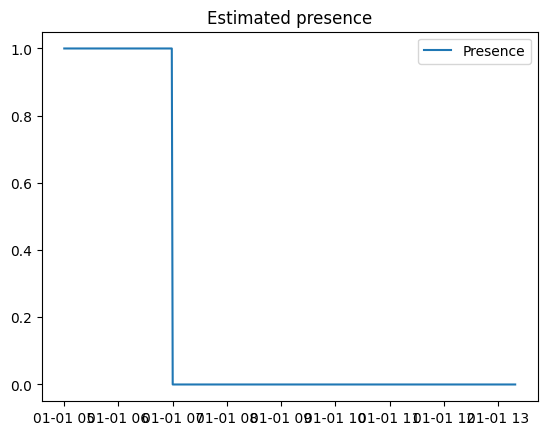

In [12]:
#time = range(len(state_ests))
ests_df = pd.DataFrame(data=state_ests[:500], index=df.index[:500], columns=['Presence'])
g = sns.lineplot(data=ests_df).set(title='Estimated presence')

In [6]:
# Print states
print("Estimated states")
print([id2hstates[x] for x in state_ests])

print("Learned emission probs:")
print(model.emissionprob_)

print("Learned transition matrix:")
print(model.transmat_)

Estimated states
['present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'pr

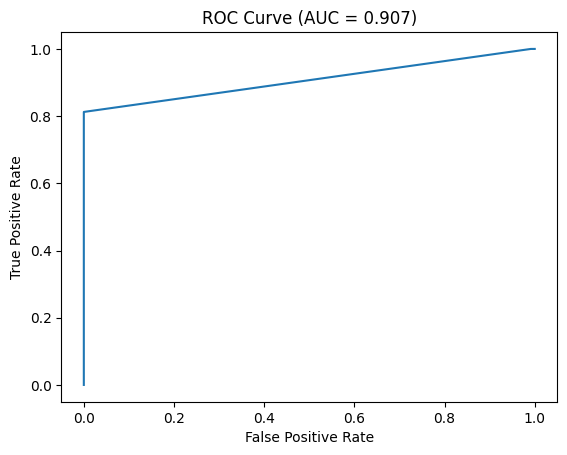

In [7]:


y_true = df['Ground Truth']

# Generate predicted probabilities for each observation
y_pred_proba = np.zeros(len(y_true))
for i in range(len(y_true)):
    logprob, state_ests = model.decode(data[i].reshape(1, -1))
    y_pred_proba[i] = np.exp(logprob)

# Convert predicted probabilities to binary labels using a threshold of 0.5
y_pred = (y_pred_proba >= 0.5).astype(int)

# Compute FPR, TPR, and thresholds for different threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Compute AUC-ROC score
auc = roc_auc_score(y_true, y_pred_proba)

# ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.3f})'.format(auc))
plt.show()




In [8]:


start_time = time.time()

# Build the model
# Set up model:
model = hmm.MultinomialHMM(n_components=len(h_states),
        n_trials=n_trials,
        n_iter=50,
        init_params='')

model.n_features = len(o_states)
model.startprob_ = start_probs
model.transmat_ = trans_mat
model.emissionprob_ = emission_probs
model.fit(data)

elapsed_time = time.time() - start_time
print("Elapsed time: {:.2f} seconds".format(elapsed_time))


MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Elapsed time: 2.36 seconds
